# Simulating Ontogenetic Growth

In [154]:
## Import libraries and packages

using Pkg
Pkg.activate("..")

using DifferentialEquations, Printf, DiffEqCallbacks, Plots, Printf
gr()

Activating environment at `C:\Users\LukeVassor\Personal\GitHub\HyperallometricFecundity\Project.toml`


Plots.GRBackend()

# Ontogenetic Growth Model

In a new meta-study by Barneche *et al.* (2018), it was shown that across species, fish (95% of species studied) empirically exhibited "hyperallometric fecundity scaling". Allometric relationships occur when a biological trait, e.g. metabolic rate, or reproductive output (number of eggs, size of eggs etc) scales with body mass. Hyperallometry means that a given trait scales with mass to a power greater than 1 ($T \propto m^{\beta}$), or alternatively, the larger an individual is (mass), the disproportionately greater this trait is. In the case of the Barneche *et al.* study, empirical data showed that the larger a fish mother is, the greater is total reproductive output, with obvious implications for fisheries management. <br/><br/>
**The goal of my research** was to use biological theory to conduct growth simulations and see if these empirical results align with out theoretical expectations.<br/><br/>
To do this I simulate growth according to a biphasic (two-part) ontogenetic growth model, in order to find theoretically optimal reproductive parameters - the proportion of body mass devoted to fecundity (reproduction), and the mass-scaling (allometric) exponent. Ontogenetic growth simply means growth throughout the biologically-distinct phases of life (e.g. juvenile, mature adult etc). This model consists of differential equations describing growth under two distinct ontogenetic phases. Firstly, a juvenile phase, where age is less than age-at-maturity, or $t < \alpha$ and mass is less than mass-at-maturity, or $m < m_{\alpha}$. Under this regime, energy for growth is lost only to cellular maintenance, as described my Metabolic Theory of Ecology (West *et al.*, 2001), with no diversion to reproduction. Post-maturity, individuals then lose energy to reproduction as well, where they devote a proportion of their body mass $c$, and which scales with body mass to the exponent $\rho$ (allometric scaling relationship).

$$
\frac{dm}{dt} = am^{x} - bm^y \qquad \quad t < \alpha
$$<br/>
$$
\frac{dm}{dt} = am^{x} - bm^y - cm^{\rho} \ \ t \geq \alpha
$$

where $am^x$ is energy intake, $bm^y$ is maintenace metabolism and $cm^{\rho}$ is reproductive output, all with their mass-scaling exponents $x$, $y$ and $\rho$, respectively.

# Optimising Life History
In order to determine "optimal" reproduction parameters, we need to define and quantify what "optimal" means in terms of biology. Evolutionary Life History Theory predicts that evolution will always select for life history parameters (e.g. age-at-maturity, size-at-maturity) which maximises the number of offspring an inidivudal produces across its lifetime (mature phase, $t > \geq \alpha$). Under this paradigm, the "fitness" of an individual can be considered it's lifetime reproductive output. The fitness ($R_0$ in this notebook) of an individual growing according to the model above can be obtained by integrating the product of an individual's lifetime  reproductive output ($cm^{\rho}$) and a mortality rate, or $\mathbb{P}$(survival). The reason we take this product is because at any time $t$ the **realised** offspring produced by individual is equivalent to the instantaneous allocation, multiplied by the individual's probability of being alive at time $t$. Thus at time $t$, the **total** offspring produced by an individual is the integral of this quantity, from the age-at-maturity $\alpha$ to time $t$ (or to $\infty$ for lifetime reproduction).

$$
R_0 = \int_\alpha^\infty cm^{\rho} L(t) dt
$$

This mortality function is set to an exponential decay function here:

$$
L(t) = e^{-\kappa t}
$$

where $\kappa$ is a rate parameter controling the rate at which the likelihood of survival decreases - the larger $\kappa$ is, the steeper the drop in survival with time.

# Define growth model as function

In [17]:
function dM(dM,M,p,t)
    intak = p[:a_0] * (abs(M[1]) ^ p[:a_b])
    maint = p[:b_0] * (abs(M[1]) ^ p[:b_b])

    if t < p[:Alph] 
        repro = 0.0
    else
        repro = p[:c_0] * (abs(M[1]) ^ p[:c_b])
        
        end
        
    dM[1] = intak - maint - repro
    dM[2] = repro * exp(-(p[:k]+p[:Z])*(t-p[:Alph]))    
end

dM (generic function with 1 method)

# Starting Parameters
In order to start the simulation, the ODE solver requires starting values for numerical integration. Here I define these:

In [18]:
hypothetical_starting_mass = 0.1
hypothetical_asymptotic_mass = 15000
hypothetical_starting_reproduction = 0

0

# Growth model parameters
Here I set the values of the fixed parameters in the model:<br/>
$a$ = potential cell growth per unit time <br/>
$x$ (```a_b```) = mass-scaling exponent of energy-intake rate. West *et al.* (2001) set this to 0.75 because they assume energy-intake rate is linked to resting metabolic rate. Recent publications suggest that energy-intake rate is actually linked to **active** metabolic rate, which scales with mass to the $0.85$ power. Here I use both. <br/>
$\alpha$ = age-at-maturity.

In [38]:
a = 2.15
a_b = 0.75
b = a/(hypothetical_asymptotic_mass^0.25)
c = 0.001 # West et al. assume 0.1 from Peters
alpha = 200

200

Here I initialise arrays for the variable parameters: <br/>
$c$ = proportion of body mass dedicated to reproduction. West *et al.* (2001) calculate this to be $\approx$ 10% somatic body mass. Other studies have suggested as high as 30%, although estimates vary depending on the method of assessing this proportion. As such I take the simulation from 0.1% to 50%. <br/>
$\rho$ = mass-scaling exponent for bodymass. <br/>
resolution = step-size for the above arrays. resolution$^2$ is the size of the resulting matrix of $c-\rho$ combinations. 

In [155]:
resolution = 50
k_vec = [0.01]
a_b_vec = [0.75,0.85]
resolution = 100
c_vec = range(0.001, 0.5, length = resolution)
c_b_vec = range(0.001, 1.25, length = resolution)
xticks = 0:10:100
yticks = 0:10:100

0:10:100

# Simulation Proper
Here I loop through different mortality rates set by $\kappa$ (```k_vec```) and different scaling exponents for energy intake rate set by $\beta$ (```a_b_vec```). Within each $\kappa - \beta$ combination I then simulate growth trajectories across a large range of $c-\rho$ combinations. At this point it is useful to review the anatomy of the growth model and go "under-the-hood" of the ODE solver. Reproduction kicks in at maturity ($t = \alpha$), but the amount of energy allocated to reproduction  scales with mass ($cm^{\rho}$), therefore the larger an individual grows pre-maturity, the larger the "drop" in overall size when maturity kicks in.<br/><br/>

Numerical integrators (ODE solvers) work by taking a small step out from an initial starting value and a series of small steps thereafter. If the drop in growth caused by the onset of reproduction is larger than the mass at $t_{\alpha} - 1$, mass drops to below zero, which breaks the solver. To this point, if this drop occurs in any form, whether mass drops to below zero or not, this implies that the individual subject to this growth curve experiences shrinking at maturity, which is, of course, biologically impossible - no individual has been observed to shed mass in order to become fecund. An individual will shrink if the terminal size is too _______________ Therefore, I took measures to omit shrinking trajectories from the simulation due to biologically infeasibility. Of the remaining feasible trajectories, the optimal $c-\rho$ combination is that which maximises $R_0$ (third dimension in a heatmap). <br/><br/>

# Define Simulation Functions
```dM``` is the growth model differential equation.
```findOptimum``` takes a matrix of lifetime reproduction values ($R_0$) resulting from feasible growth curves and returns the $c$-$\rho$ combination which maximises $R_0$. <br/>
```plotHeatmap``` plots this matrix of $R_0$ values as heatmap and highlights the optimum $c$-$\rho$. <br/>
```growthCurves``` simulates lifetime growth by integrating ```dM```. At maturity it uses different $c$-$\rho$ combinations and returns the total lifetime reproduction $R_0$ when growth is affected by this combination.

In [152]:
function findOptimum(growthCurves, c_vector, rho_vector)
        ## Find optimum values from matrix
        max = findmax(growthCurves)
        c_opt = c_vector[max[2][1]]
        rho_opt = rho_vector[max[2][2]]

        return (c_opt, rho_opt)
end


function plotHeatmap(growthCurves, optima, c_vector, rho_vector, a_b)
    c_opt = optima[1]
    rho_opt = optima[2]
    
    ## Set plot attributes
    xticks_labels = 0.00:maximum(c_vector)/10:maximum(c_vector)
    yticks_labels = 0.00:maximum(rho_vector)/10:maximum(rho_vector)

    map = heatmap(growthCurves, xlab="Proportion of body mass to fecundity rate, c",xticks = (xticks,xticks_labels),
                        ylab="Fecundity rate mass-scaling exp, p", yticks = (yticks,yticks_labels),
                        transpose=true, legend = :none, title = "Optimal life history parameters when intake rate scaling exponent = $(@sprintf("%.2f", a_b))",
                    titlefontsize=11)
    annotation_string = "Optima:\nc opt = $(@sprintf("%.2f", c_opt))\nrho opt = $(@sprintf("%.2f", rho_opt))"
    annotate!([(80, 90, text(annotation_string, 10, :white, :left))])
    annotate!([(c_opt*resolution/maximum(c_vector), rho_opt*resolution/maximum(rho_vector), text("O", 12, :white))])
    display(map)
end


function growthCurves(kappa_vector, intake_exponent_vector, starting_mass, starting_reproduction, c_vector, rho_vector, resolution)
    for g in 1:length(kappa_vector) # loop through different mortality rates kappa
        k = kappa_vector[g]
        for h in 1:length(intake_exponent_vector) # loop through different intake rate scalings
            a_b = intake_exponent_vector[h]
            M0 = [starting_mass, starting_reproduction] # set array of starting values for integrator
            tspan = (0.0,1e4) # long time span ensures simulation reaches completion
            
            ## Calculate which curves have an asymptotic size (no repro) larger than m_alpha (i.e. no shrinking) ##
            ## when reproduction is from birth ##
            results_no_shrink = Array{Float64,2}(undef,resolution,resolution)
#             print(results_no_shrink)
            results_optimisation = Array{Any,2}(undef,resolution,resolution)
            for i in 1:resolution # loop through empty matrix with different c and rho values
                c_0 = c_vector[i]
                for j in 1:resolution # simulate growth curve in each matrix cell and store result
                    c_b = rho_vector[j]
                    p = Dict([(:a_0,a),(:a_b,a_b),
                    (:b_0,b),(:b_b,1.0),
                    (:c_0,c_0),(:c_b,c_b),
                    (:Alph,alpha),
                    (:k,k),(:Z,2/alpha)])
                    prob = ODEProblem(dM,M0,tspan,p)
                    sol_optimisation = solve(prob,Rosenbrock23()) 
                    results_optimisation[i,j] = sol_optimisation
                    global M_alph = sol_optimisation(p[:Alph])[1]
                    p[:Alph] = 0.0 # update p value, MUST come AFTER prob defined
                    prob = ODEProblem(dM,M0,tspan,p)
                    sol_no_shrink = solve(prob,Rosenbrock23())
                    results_no_shrink[i,j] = sol_no_shrink[end][1]
                end
            end
#             print("\nM_alpha: ", M_alph, " grams")
            feasibleCurves = results_no_shrink .> M_alph # bool matrix of feasible growth curves where asmyptotic size is larger than mass a maturity (i.e.) those curves with no shrinking
            lifetimeRepro = [i.u[end][2] for i = results_optimisation] # find R0 of each simulated growth curve
            finalCurves = lifetimeRepro .* feasibleCurves
            optima = findOptimum(finalCurves, c_vec, c_b_vec)
            plotHeatmap(finalCurves, optima, c_vec, c_b_vec, a_b)
        end
    end
    
end

growthCurves (generic function with 2 methods)

# Run the simulation

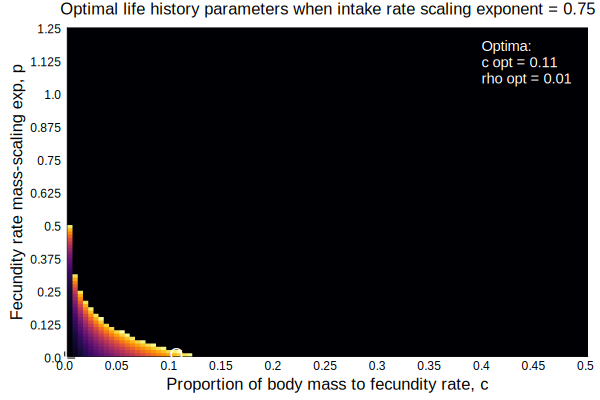

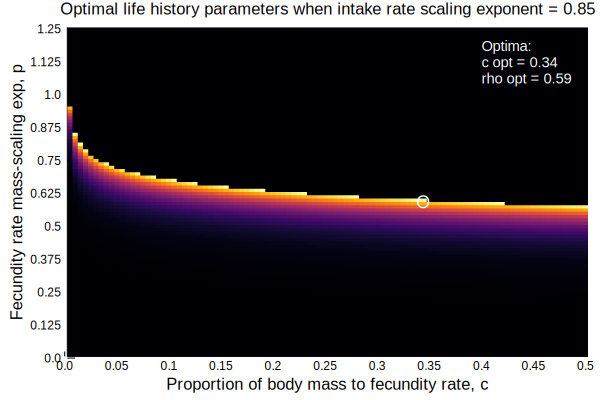

In [156]:
growthCurves(k_vec, a_b_vec, hypothetical_starting_mass, hypothetical_starting_reproduction, c_vec, c_b_vec, resolution)

# Results
As we can see from the heatmap 1 where $x$ = 0.75, the optimum $\rho$ = 0.01. This is a really interesting result because it suggests that under *status quo* intake rate scaling ($x$), energy allocation to reproduction does not scale with mass at all (since $\rho \approx$ 0). 